In [1]:
import os
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [2]:
DATA_PATH = "data/"  # Update this path to your DICOM files directory

DICOM_FILES_PATH = os.path.join(DATA_PATH, "*.dcm")
dicom_data = pd.DataFrame([{"path": filepath} for filepath in glob(DICOM_FILES_PATH)])
dicom_data["file"] = dicom_data["path"].map(os.path.basename)

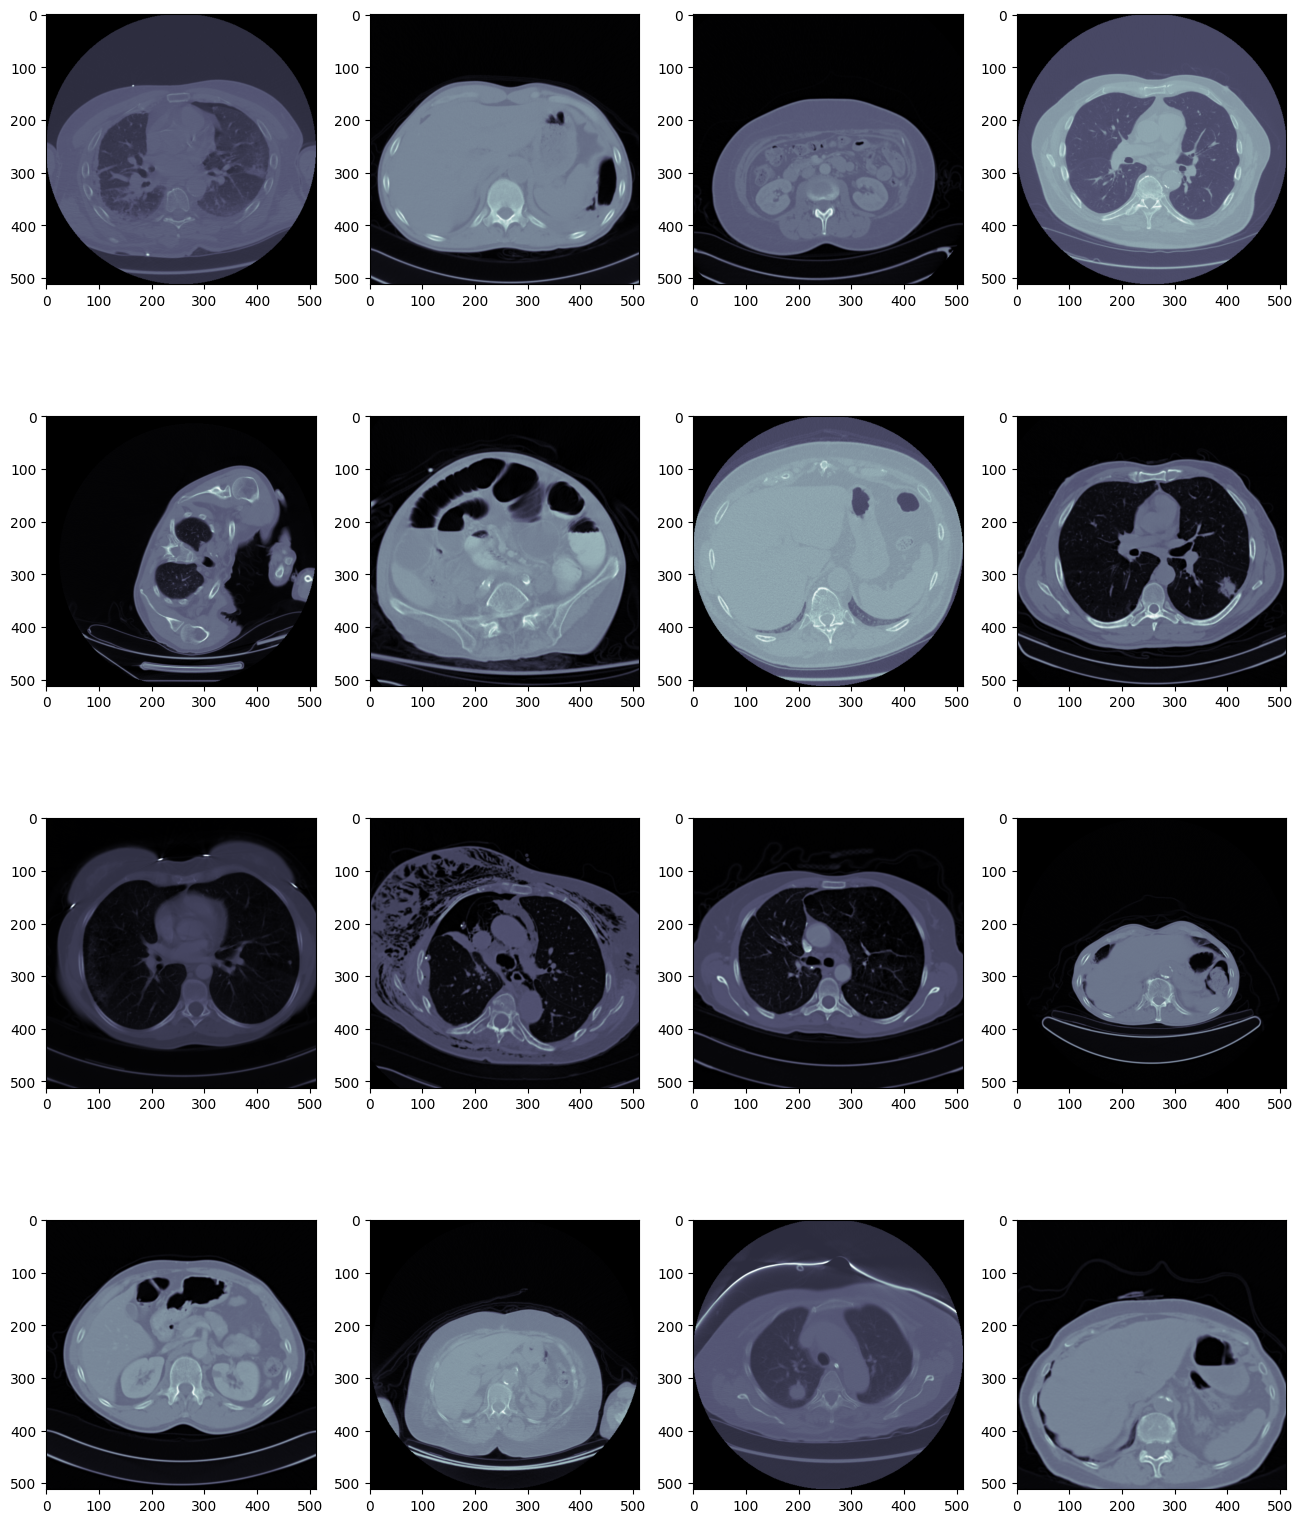

In [3]:
# Show 16 DICOM images in a 4x4 grid
img_data = list(dicom_data[:16].T.to_dict().values())
f, ax = plt.subplots(4, 4, figsize=(16, 20))
for i, data_row in enumerate(img_data):
    data_row_img = pydicom.dcmread(data_row["path"])
    ax[i // 4, i % 4].imshow(data_row_img.pixel_array, cmap=plt.cm.bone)
plt.show()

In [4]:
# Show all DICOM metadata of one file
dicom_file_path = list(dicom_data[:1].T.to_dict().values())[0]["path"]
dicom_file_metadata = pydicom.dcmread(dicom_file_path)
print(dicom_file_metadata)

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 196
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6450.4012.266402896965029418188277260373
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.34'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008,0012) Instance Creation Date              DA: '19950131'
(0008,0013) Instance Creation Time              TM: '091428'
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0018) SOP Instance UID      

## Connection to MogoDB

In [ ]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017")

try:
    client.admin.command("ping")
    print("Successfully connected to MongoDB")
except Exception as e:
    print(e)

Successfully connected to MongoDB


### Generate Surrogate Keys
- Create a function surrogate_key(values) that receives a dictionary and returns a unique
hash string.
- You can use the hashlib library with the MD5 algorithm.
- Ensure the same combination of values always produces the same key.

In [ ]:
import hashlib

def surrogate_key(values: dict) -> str:
    hash_input = "|".join([str(v) for v in values.values()])
    return hashlib.md5(hash_input.encode()).hexdigest()

### Insert or Retrieve Dimension Records
- Define a function get_or_create(collection, values, pk_name) that checks if a record
exists in a MongoDB collection.
- If it does not exist, insert a new one using the surrogate key as a primary key.
- Return the surrogate key in both cases.

In [ ]:
from pymongo.collection import Collection

def get_or_create(collection: Collection, values: dict, pk_name: str):
    # Generate surrogate key
    sk = surrogate_key(values)
    # Check if document with this surrogate key already exists
    existing_doc = collection.find_one({pk_name: sk})
    
    if existing_doc:
        return existing_doc[pk_name]
    # If not, insert new document
    values[pk_name] = sk
    collection.insert_one(values)
    return sk

### Format Patient Age
- Write format_age(age_str) to transform a DICOM age string such as '061Y' into an
integer (e.g., 61).
- Handle missing or malformed data safely.

In [8]:
def format_age(age_str: str) -> int | None:
    """Convert DICOM age string (e.g., '045Y') to integer years."""
    if not age_str or len(age_str) != 4:
        return None
    return int(age_str[:3])

### Convert DICOM to JPEG
- Implement dicom_to_jpeg(input_path, output_dir, size) and save the images in a new
folder. The new paths must be saved in the fact table:
- Read a DICOM file using pydicom.
- Normalize pixel values to 0–255.
- Resize to 256x256 and save the image as a grayscale JPEG.
- Ensure the output directory exists and the image name corresponds to the input file
name.

In [26]:
import os
from PIL import Image
import numpy as np


def dicom_to_jpeg(input_path, output_dir, size):
    try:
        os.makedirs(output_dir, exist_ok=True)
        dicom_data = pydicom.dcmread(input_path)
        pixel_array = dicom_data.pixel_array

        pixel_array = pixel_array.astype(float)
        min_pixel = pixel_array.min()
        max_pixel = pixel_array.max()

        if max_pixel > min_pixel:
            scaled_pixel_array = (
                (pixel_array - min_pixel) / (max_pixel - min_pixel)
            ) * 255.0
        else:
            scaled_pixel_array = np.zeros_like(pixel_array)

        image = Image.fromarray(scaled_pixel_array.astype(np.uint8), mode="L")
        image = image.resize(size, Image.LANCZOS)
        output_path = os.path.join(
            output_dir, os.path.basename(input_path).replace(".dcm", ".jpeg")
        )
        image.save(output_path, "JPEG")

        return output_path

    except Exception as e:
        print(f"Error processing {input_path}: {e}")
        return None

### Normalize Pixel Spacing
- Create normalize_pixel_spacing(raw_value) to round a numeric pixel spacing value to
the nearest bin within a predefined set of values (0.6, 0.65, 0.7, 0.75, 0.8).

In [9]:
def round_to_nearest_bin(value, bins):
    """Round a value to the nearest bin."""
    return min(bins, key=lambda x: abs(x - value))


def normalize_pixel_spacing(raw_value):
    """Convert DICOM PixelSpacing to a list of floats."""
    if not raw_value:
        return None
    normalized = [float(v) for v in raw_value]
    bins = [0.6, 0.65, 0.7, 0.75, 0.8]
    return [round_to_nearest_bin(v, bins) for v in normalized]

### Normalize Contrast Agent Field
- Write normalize_contrast_agent(val) to standardize DICOM contrast agent metadata:
- Replace missing, empty, or single-character values with "No contrast agent".
- Otherwise, return the cleaned string.

In [30]:
def normalize_contrast_agent(raw_value):
    if not raw_value or raw_value == "":
        return "No contrast agent"

    if len(raw_value) == 1:
        return "No contrast agent"

    return raw_value.lower().strip()

## Get the info for the dimensions


In [24]:
patient = {
    "PatientID": dicom_file_metadata.PatientID,
    "PatientAge": dicom_file_metadata.PatientAge,
    "PatientSex": dicom_file_metadata.PatientSex,
}

image = {
    "SliceThickness": dicom_file_metadata.get("SliceThickness", ""),
    "PixelSpacing": dicom_file_metadata.get("PixelSpacing", ""),
    "Rows": dicom_file_metadata.Rows,
    "Columns": dicom_file_metadata.Columns,
    "PhotometricInterpretation": dicom_file_metadata.PhotometricInterpretation,
}

station = {
    "Manufacturer": dicom_file_metadata.get("Manufacturer", ""),
    "ModelName": dicom_file_metadata.get("ManufacturerModelName", ""),
}

protocol = {
    "BodyPartExamined": dicom_file_metadata.get("BodyPartExamined", ""),
    "ContrastAgent": dicom_file_metadata.get("ContrastBolusAgent", ""),
    "PatientPosition": dicom_file_metadata.get("PatientPosition", ""),
}

date = {
    "StudyDate": dicom_file_metadata.get("StudyDate", ""),
}

In [25]:
surrogate_key(patient)

'47d1d447552cba630b9337b6dab12e31'

In [27]:
normalize_pixel_spacing(image["PixelSpacing"])

[0.7, 0.7]

In [29]:
format_age(patient["PatientAge"])

67

In [31]:
normalize_contrast_agent(protocol["ContrastAgent"])

'No contrast agent'

In [32]:
dicom_to_jpeg(dicom_file_path, "collections", (256, 256))

/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_36145/2793900194.py:23: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image = Image.fromarray(scaled_pixel_array.astype(np.uint8), mode="L")


'collections/ID_0062_AGE_0067_CONTRAST_0_CT.jpeg'